In [1]:
import numpy as np
import pandas as pd
import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from dataprep.eda import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#init_notebook_mode(connected=True)

NumExpr defaulting to 8 threads.


C:\Users\pitso\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## File structures

### Train dataset
* Each line of this file after the header row represents one rating of one movie by one user, and has the following format.
* Columns: userId,movieId,rating,timestamp
* Rows: 10000038

### Movies dataset
* Each line of this file after the header row represents one movie
* Columns: movieId,title,genres
* Rows: 62423

### Tags dataset
* Each line of this file after the header row represents one tag applied to one movie by one user
* Columns: userId,movieId,tag,timestamp
* Rows: 1093360

### Links dataset
* Identifiers that can be used to link to other sources of movie data are contained in the file
* Columns: movieId,imdbId,tmdbId
* Rows: 62423

### Genome_scores dataset
* Provides the tag descriptions for the tag IDs
* Columns: tagId,movieId,relevance
* Rows: 15584448

### Genome_tags dataset
* Contains movie-tag relevance data
* Columns: tagId,tag
* Rows: 1128

#### Entity relationship diagram showing the data relationships between the data entities

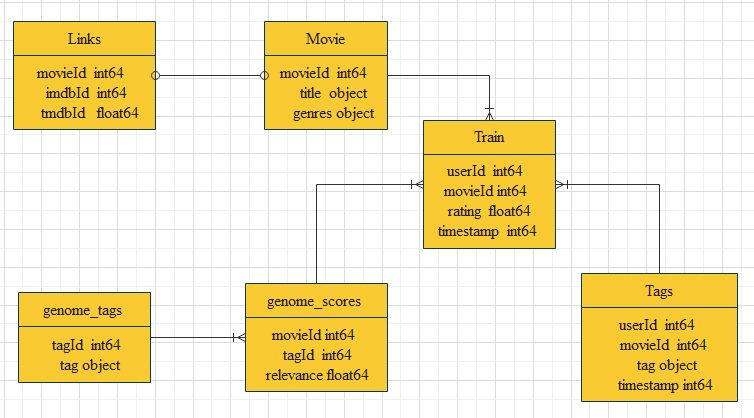

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')
imdb_data = pd.read_csv('imdb_data.csv')
genome_tags = pd.read_csv('genome_tags.csv')
genome_scores = pd.read_csv('genome_scores.csv')

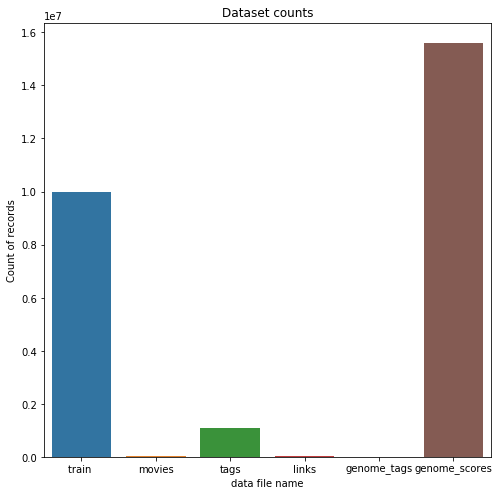

In [3]:
train = train.shape[0] 
movies = movies.shape[0]
tags = tags.shape[0]
links = links.shape[0]
genome_tags = genome_tags.shape[0]
genome_scores = genome_scores.shape[0]
plt.figure(figsize=(8,8))
sns.barplot(['train ','movies','tags','links','genome_tags','genome_scores'],[train,movies,tags,links,genome_tags,genome_scores]) #Use seaborn barplot and add a list of classes
plt.xlabel('data file name') #X-label of the data
plt.ylabel('Count of records')      #Y_label of the data
plt.title('Dataset counts') #Give the data a title 'Dataset lables distribution'
plt.show() #Display the dataset

In [7]:
""""  
def get_date(title1):
    if '(' in title1:
        return title1.split('(')[1].split(')')[0].strip()
    else:
        return 'Unknown'
"""""

In [8]:
# Lets create a new column for the titles
#movies['Release Date'] = movies['title'].map(lambda x: get_date(x))

In [49]:
pd.set_option('display.max_colwidth', None)

In [124]:
#extract only the release date from title
rem_char = ['(',')']
title = movies['title']
for c in rem_char:
    title = title.replace(c, " ")
#movies['title2']= movies['title'].replace(rem_char, '').str.strip()
   # 

In [130]:
def textPreprocessing(data):
    #Remove Punctuation Logic
    import string
    removePunctuation = [char for char in data if char not in string.punctuation]
    #Join Chars to form sentences
    sentenceWithoutPunctuations = ''.join(removePunctuation)
    
    return sentenceWithoutPunctuations

In [134]:
#remove unwanted characters
movies['title2'] = movies['title'].apply(textPreprocessing).str.strip()

In [147]:
#extract the last the year ffrom the title
movies['Release_Date'] = movies['title2'].str.strip().str[-4:]
#convert non numeric years to zero/unknown 
movies.loc[movies['Release_Date'].str.isdigit() == False,'Release_Date'] = 0 
movies.drop('title2', axis=1, inplace=True)

In [163]:
plot(movies,'Release_Date',largest=True)

In [10]:
plot(movies,'genres',largest=True)

In [171]:
#limit the size of the data to read. This will enable the plot to run quickly
train10=train.sample(frac = 0.1,replace=False, random_state=1)
print(train10.shape)
plot(train10,'rating',bins=20)

(1000004, 4)


In [14]:
#tags10 = tags.sample(frac=0.1)
print(tags.shape)
plt.figure(figsize=(10,10))
plot(tags,'tag',largest=True)

(1093360, 4)


<Figure size 720x720 with 0 Axes>

In [170]:
plot_missing(tags,'tag')

In [169]:
genome_scores10 = genome_scores.sample(frac=0.1,replace=False, random_state=1)
print(genome_scores10.shape)
plt.figure(figsize=(10,10))
plot(genome_scores10,'relevance',largest=True)

(1558445, 3)


<Figure size 720x720 with 0 Axes>

In [165]:
#merge recency dataframe with frequency dataframe with monetary_dataframe
train_movies = pd.merge(train,movies, how='left',on='movieId')
train_movies_score = pd.merge(train_movies,genome_scores, how='left',on='movieId')
#rece_freq_money_df = rece_freq_df.merge(monetary_df,on='CustomerID')

print(train_movies_score.shape)
train_movies_score.head()

MemoryError: Unable to allocate 82.9 GiB for an array with shape (11132980634,) and data type int64

In [15]:
print("train data" + '\n', train.head())
print("movies data" + '\n', movies.head())
print("tags data" + '\n', tags.head())
print("links data" + '\n', links.head())
print("genome_tags data" + '\n', genome_tags.head())
print("genome_scores data" + '\n', genome_scores.head())
#train.head(5)

train data
    userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837
movies data
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
tags data
    userId  movieId               tag   timestamp
0       3      260           classic  1439472355
1       3      260            sci-fi 

In [20]:
print('Shape of Train Dataset:',train.shape)
#print('Shape of Test Dataset:',test_df.shape)
print('Shape of Movies Dataset:',movies.shape)
#print('Shape of genres Dataset:',genres.shape)
print('Shape of tags Dataset:',tags.shape)
print('Shape of links Dataset:',links.shape)
print('Shape of genome_tags Dataset:',genome_tags.shape)
print('Shape of genome_scores Dataset:',genome_scores.shape)


Shape of Train Dataset: 10000038
Shape of Movies Dataset: (62423, 3)
Shape of tags Dataset: (1093360, 4)
Shape of links Dataset: (62423, 3)
Shape of genome_tags Dataset: (1128, 2)
Shape of genome_scores Dataset: (15584448, 3)


In [ ]:
#plt.hist(users['Age'])
#finalDF.groupby('Rating')['UserID'].count().plot(kind='pie')
#•	Visualize user age distribution 
#sns.distplot(users['Age'])

In [19]:
print("empty cells in train dataset" + "\n", train.isnull().sum())
print("empty cells in movies dataset" + "\n", movies.isnull().sum())
print("empty cells in tags dataset" + "\n", tags.isnull().sum())
print("empty cells in links dataset" + "\n", links.isnull().sum())
print("empty cells in genome_tags dataset" + "\n", genome_tags.isnull().sum())
print("empty cells in genome_scores dataset" + "\n", genome_scores.isnull().sum())

empty cells in train dataset
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
empty cells in movies dataset
 movieId    0
title      0
genres     0
dtype: int64
empty cells in tags dataset
 userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
empty cells in links dataset
 movieId      0
imdbId       0
tmdbId     107
dtype: int64
empty cells in genome_tags dataset
 tagId    0
tag      0
dtype: int64
empty cells in genome_scores dataset
 movieId      0
tagId        0
relevance    0
dtype: int64


In [ ]:
#remove duplicates from the tables


In [ ]:
#function to tranform the timestamps into normal dates

In [ ]:
#separate the release date from the movie title

In [ ]:
#train['message_length'].groupby(train['sentiment']).describe()